In [ ]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download en_core_web_lg

In [ ]:
!pip install --upgrade plotly

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px

# Load Data

In [2]:
reviews = pd.read_csv('reviews.csv')

In [3]:
reviews.head()

,name,title,review,rating,rating_out_of,date
0,Shweta,Seems authentic,Looks authentic...lot different than regular h...,5.0,5.0,2021-11-26
1,Altaf,Honey with full of sugar. Fake honey.,NaN,1.0,5.0,2021-11-25
2,Aditya,Note,Bahut sare try kare h maine but boss ye waha b...,5.0,5.0,2021-11-25
3,NAVEEN KUMAR,Worst product Only sugar,Worst product this is.Only sugar. That too bad...,1.0,5.0,2021-11-24
4,Suresh,Good tastes,Good taste,5.0,5.0,2021-11-24


# Clean Data

In [6]:
def correct_spellings(phrase):
  corrections = {
    'pricethe': 'price the',
    'loudnessand': 'loudness and',
    'muffeled': 'muffled',
    'expidite': 'expedite',
    'suerb': 'superb',
    'eeplaces': 'ear pieces',
    'exilent': 'excellent',
    'worthable': 'worth able',
    'soundaverage': 'sound average',
    'bukd': 'build',
    'breliant': 'brilliant',
    'dvsvinyl': 'dvd vinyl',
    'qudoes': 'kudos',
    'extarnal': 'external',
    'heaten': 'heats',
    'iseent': 'is not',
    'worth the prize': 'worth the price',
    "laptop's": 'laptop',
    "laptop’s": 'laptop',
    "aslo": "also",
    "qulity": "quality",
    "qaulity": "quality",
    "sable": "cable" 
  }
  for k, v in corrections.items():
    phrase = phrase.replace(f"{k}", v)
  return phrase

def undo_contractions(phrase):
    # specific
    phrase = re.sub(r"won[\'’]t", "will not", phrase)
    phrase = re.sub(r"can[\'’]t", "can not", phrase)

    # general
    phrase = re.sub(r"n[\'’]t", " not", phrase)
    phrase = re.sub(r"[\'’]re", " are", phrase)
    phrase = re.sub(r"[\'’]s", " is", phrase)
    phrase = re.sub(r"[\'’]d", " would", phrase)
    phrase = re.sub(r"[\'’]ll", " will", phrase)
    phrase = re.sub(r"[\'’]t", " not", phrase)
    phrase = re.sub(r"[\'’]ve", " have", phrase)
    phrase = re.sub(r"[\'’]m", " am", phrase)
    return phrase

emoji_regex = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)

reviews['text'] = reviews['title'] + ' . ' + reviews['review']

reviews['text_cleaned'] = (reviews['text']
  .fillna('')
  .str.replace(r'([a-z]+)([A-Z])', r'\1 \2') # badProduct bad Product
  .str.lower()
  .str.replace(emoji_regex, '')
  .str.replace('\n', '.')
  .str.replace(r'\s*\.+\s*', '. ') # dots and spaces
  .str.replace(r'([\{\(\[\}\)\]])', r' \1 ') # spaces between parenthesis
  .str.replace(r'([:])', r' \1 ') # spaces between :
  .str.replace(r'(\d+\.?\d*)', r' \1 ') # spaces between numbers
  .apply(correct_spellings)
  .apply(undo_contractions)
)

In [7]:
reviews['text_cleaned'].head()

0    seems authentic. looks authentic. lot differen...
1                                                     
2    note. bahut sare try kare h maine but boss ye ...
3    worst product only sugar. worst product this i...
4                              good tastes. good taste
Name: text_cleaned, dtype: object

# Extract (Aspect, Opinion) Pairs

In [5]:
nlp = spacy.load("en_core_web_lg")

In [8]:
def extract_aspects(doc):

    prod_pronouns = ['it','this','they','these']

    rule1_pairs = []
    rule2_pairs = []
    rule3_pairs = []
    rule4_pairs = []
    rule5_pairs = []
    rule6_pairs = []
    rule7_pairs = []

    for token in doc:
        if token.text == 'product':
          continue

        ## FIRST RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## RULE = M is child of A with a relationship of amod
        A = "999999"
        M = "999999"
        if token.dep_ == "amod" and not token.is_stop:
            M = token.text
            A = token.head.text

            # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
            M_children = token.children
            for child_m in M_children:
                if(child_m.dep_ == "advmod"):
                    M_hash = child_m.text
                    M = M_hash + " " + M
                    break

            # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
            A_children = token.head.children
            for child_a in A_children:
                if(child_a.dep_ == "det" and child_a.text == 'no'):
                    neg_prefix = 'not'
                    M = neg_prefix + " " + M
                    break

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict1 = {"noun" : A, "adj" : M, "rule" : 1}
            rule1_pairs.append(dict1)


        # # SECOND RULE OF DEPENDANCY PARSE -
        # # M - Sentiment modifier || A - Aspect
        # Direct Object - A is a child of something with relationship of nsubj, while
        # M is a child of the same something with relationship of dobj
        # Assumption - A verb will have only one NSUBJ and DOBJ
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text

            if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                M = child.text

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict2 = {"noun" : A, "adj" : M, "rule" : 2}
            rule2_pairs.append(dict2)


        ## THIRD RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Adjectival Complement - A is a child of something with relationship of nsubj, while
        ## M is a child of the same something with relationship of acomp
        ## Assumption - A verb will have only one NSUBJ and DOBJ
        ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text

            if(child.dep_ == "acomp" and not child.is_stop):
                M = child.text

            # example - 'this could have been better' -> (this, not better)
            if(child.dep_ == "aux" and child.tag_ == "MD"):
                neg_prefix = "not"
                add_neg_pfx = True

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict3 = {"noun" : A, "adj" : M, "rule" : 3}
            rule3_pairs.append(dict3)


        ## FOURTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
        # M is a child of the same something with relationship of advmod

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                A = child.text

            if(child.dep_ == "advmod" and not child.is_stop):
                M = child.text
                M_children = child.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + child.text
                        break

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict4 = {"noun" : A, "adj" : M, "rule" : 4}
            rule4_pairs.append(dict4)

        ## FIFTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Complement of a copular verb - A is a child of M with relationship of nsubj, while
        # M has a child with relationship of cop

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        buf_var = "999999"
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text

            if(child.dep_ == "cop" and not child.is_stop):
                buf_var = child.text

        if(A != "999999" and buf_var != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict5 = {"noun" : A, "adj" : token.text, "rule" : 5}
            rule5_pairs.append(dict5)


        ## SIXTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)

        children = token.children
        A = "999999"
        M = "999999"
        if(token.pos_ == "INTJ" and not token.is_stop):
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    M = token.text

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict6 = {"noun" : A, "adj" : M, "rule" : 6}
            rule6_pairs.append(dict6)

        ## SEVENTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## ATTR - link between a verb like 'be/seem/appear' and its complement
        ## Example: 'this is garbage' -> (this, garbage)

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text

            if((child.dep_ == "attr") and not child.is_stop):
                M = child.text

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict7 = {"noun" : A, "adj" : M, "rule" : 7}
            rule7_pairs.append(dict7)

    aspects = []

    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs + rule7_pairs

    return aspects

In [29]:
aspects = []

data = ([
         (x[1], x[0]) for x in reviews['text_cleaned'].reset_index().to_numpy()
])

def has_vectors(doc):
  return np.all([token.has_vector for token in doc])

for doc, review_id in nlp.pipe(data, as_tuples=True):
  doc_aspects = extract_aspects(doc)
  doc_aspects = [
      [review_id, aspect['noun'], aspect['adj'], aspect['rule']] 
      for aspect in doc_aspects if not aspect['noun'].lower().startswith('product')
  ]
  doc_aspects = [
    doc_aspect for doc_aspect in doc_aspects 
    if has_vectors(nlp(doc_aspect[1]))
  ]
  aspects.extend(doc_aspects)

aspects = pd.DataFrame(aspects, columns=['review_id', 'aspect', 'opinion', 'rule'])

In [30]:
aspects

,review_id,aspect,opinion,rule
0,0,lot,different,1
1,0,honey,regular,1
2,2,packaging,great,1
3,3,smell,too bad,1
4,4,tastes,good,1
...,...,...,...,...
1602,743,quality,nice,1
1603,744,honey,nice,1
1604,744,honey,thick,1
1605,745,purchases,repeated,1


In [23]:
# design better rules or 
# better post processing

In [24]:
aspects.query('aspect == "quality"').groupby('rule').size()

Series([], dtype: int64)

In [25]:
aspects.query('aspect != "quality"').groupby('rule').size()

rule
1    6
6    1
7    1
dtype: int64

# Cluster similar together

In [31]:
from sklearn.cluster import AgglomerativeClustering

def cluster_aspect_terms(aspects):

  aspect_terms = sorted(list(set(aspects['aspect'].values)))

  aspect_terms_sizes = aspects.groupby('aspect').size().sort_index().values

  aspect_terms_vectors = [doc.vector for doc in nlp.pipe(aspect_terms)]

  clusterer = AgglomerativeClustering(n_clusters=None,
                                      affinity='cosine',
                                      linkage='average',
                                      distance_threshold=0.2)

  clusterer.fit(aspect_terms_vectors)

  term_replacements = {}

  for cluster in range(clusterer.n_clusters_):

    idxs = np.nonzero(clusterer.labels_ == cluster)[0]

    terms = [t for i, t in enumerate(aspect_terms) if i in idxs]

    sizes = aspect_terms_sizes[idxs]
    
    main_term = terms[np.argmax(sizes)]

    for term in terms:
      term_replacements[term] = main_term

  return term_replacements

In [32]:
replacements = cluster_aspect_terms(aspects)
aspects['aspect'] = aspects['aspect'].map(replacements)

# Visualize New

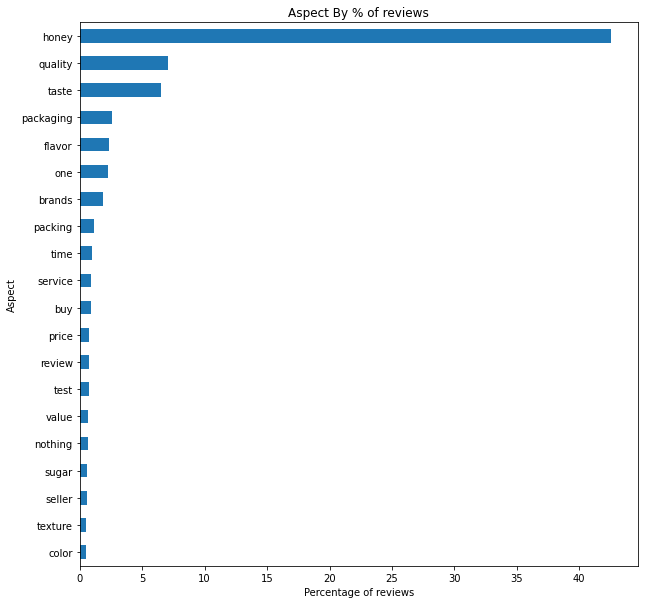

In [16]:
plt.figure(figsize=(10, 10))

ax = (
  ((aspects.groupby('aspect').size()) / len(aspects) * 100)  
  .sort_values(ascending=False)[:20][::-1]
  .plot.barh()
)

ax.set_xlabel("Percentage of reviews")
ax.set_ylabel("Aspect")
ax.set_title("Aspect By % of reviews");

In [17]:
fig = px.treemap(aspects.groupby(['aspect', 'opinion']).size().reset_index(),
    path=[px.Constant('Aspects'), 'aspect', 'opinion'],
    values=0,
)
fig.update_traces(root_color='white')
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

In [18]:
aspect_with_ratings = pd.merge(aspects,
  reviews[['rating']],
  left_on='review_id', 
  right_index=True)

aspect_with_ratings['review_sentiment'] = pd.cut(aspect_with_ratings['rating'], 
       bins=[0, 3, 4, 5], 
       right=True,
       labels=['Negative', 'Neutral', 'Positive']
)

In [19]:
pain_points = (aspect_with_ratings
    .query('review_sentiment == "Negative"')
    .groupby('aspect')
    .size()
    .sort_values(ascending=False)[:10]
)
fig = px.bar(pain_points, title='Top Pain Points (by %number of -ve reviews)')
fig.update_traces(marker_color='red', showlegend=False)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig

In [20]:
gain_points = (aspect_with_ratings
    .query('review_sentiment == "Positive"')
    .groupby('aspect')
    .size()
    .sort_values(ascending=False)[:10]
)
fig = px.bar(gain_points, title='Top Pain Points (by number of +ve reviews)')
fig.update_traces(marker_color='green', showlegend=False)
fig

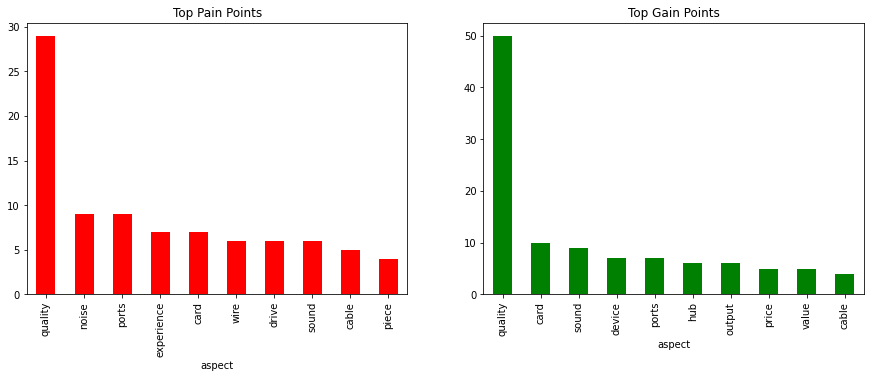

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# top pain point
(aspect_with_ratings
    .query('review_sentiment == "Negative"')
    .groupby('aspect')
    .size()
    .sort_values(ascending=False)[:10]
).plot.bar(ax=axs[0], color='red')

axs[0].set_title("Top Pain Points")

# top gain points
(aspect_with_ratings
    .query('review_sentiment == "Positive"')
    .groupby('aspect')
    .size()
    .sort_values(ascending=False)[:10]
).plot.bar(ax=axs[1], color='green')

axs[1].set_title("Top Gain Points");

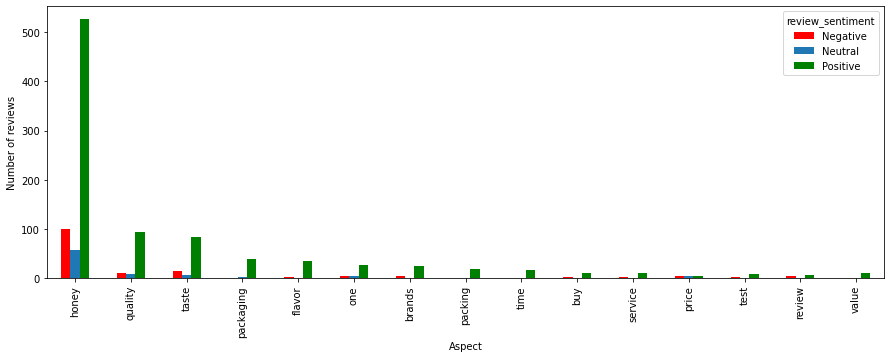

In [34]:
plt.figure(figsize=(15, 5))

pivot = pd.crosstab(
    index=aspect_with_ratings['aspect'],
    columns=aspect_with_ratings['review_sentiment'],
    margins=True,
).sort_values(by='All', ascending=False).iloc[1:, :-1]

ax = pivot[:15].plot.bar(ax=plt.gca(), color={
    'Negative': 'red',
    'Positive': 'green',
    'Neutral': '#1f77b4',
})

ax.set_xlabel("Aspect")
ax.set_ylabel("Number of reviews");

In [33]:
pivot = pd.crosstab(
    index=aspect_with_ratings['aspect'],
    columns=aspect_with_ratings['review_sentiment'],
    margins=True,
).sort_values(by='All', ascending=False).iloc[1:, :-1]

px.bar(pivot[:15], barmode='group', color_discrete_map={
    'Positive': 'green', 
    'Negative': 'red',
    'Neutral': 'blue',
}, title='Sentiment By Aspect (0-3 Negative) (4 Neutral) (5 Positive)')